In [2]:
import sys
print(sys.prefix)

C:\Users\MAUD\anaconda3\envs\bert_env


In [3]:
import pandas as pd
import numpy as np
import ast

#sauvegarde des modèles
import joblib 

#pour slugifier une string
import re
import unicodedata

#traitement
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.utils import resample
import nltk
from nltk.corpus import words
from functools import lru_cache

# modeles
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

#tracking mlflow
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
import mlflow.sklearn
from time import time
from sklearn.metrics import accuracy_score, classification_report, jaccard_score

import matplotlib.pyplot as plt


#word2vec, BERT, USE

# Imports nécessaires pour Word2Vec
from gensim.models import Word2Vec
import numpy as np

# Importer la bibliothèque transformers pour BERT
from transformers import BertTokenizer, BertModel
import torch

# Imports nécessaires pour USE
import tensorflow_hub as hub
import tensorflow as tf

#empecher les messages d'erreur
# import warnings
# warnings.filterwarnings('ignore')
# import logging
# logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

#affichage des tableaux en entier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Formatage taille cellule pour s'adapter aux graphiques
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))


df = pd.read_csv("./filtered_questions_clean.csv",sep=',', encoding='utf-8')  
df.head(5)

C:\Users\MAUD\anaconda3\envs\bert_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,title,body,link,view_count,score,answer_count,tags,creation_date,clean_title,clean_body,word_count_title,word_count_clean_title,word_count_body,word_count_clean_body
0,0,Manifest v3 background scripts/service worker ...,<p>I'm trying to migrate my browser extension ...,https://stackoverflow.com/questions/75043889/m...,17070,48,3,"['google-chrome', 'firefox', 'cross-browser', ...",2023-01-07 21:27:38,manifest v background script service worker fi...,trying migrate browser extension expect work c...,7,7,493,263
1,1,Settings Menu missing Ubuntu 22.04,<p>So I was trying to get back the menu settin...,https://stackoverflow.com/questions/74985183/s...,42944,33,4,"['ubuntu', 'menu', 'settings', 'new-operator',...",2023-01-02 17:06:35,setting menu missing ubuntu,trying get back menu setting dissapear ubutu m...,5,4,166,150
2,2,Does &#39;use client&#39; in Next.js 13 root l...,<p>I was trying Nextjs 13 with Next-auth and A...,https://stackoverflow.com/questions/74992326/d...,32460,27,2,"['javascript', 'reactjs', 'next.js', 'server-s...",2023-01-03 10:49:12,use client next j root layout make whole route...,trying nextjs next auth apollo client wrap roo...,13,11,86,41
3,3,How can I stop Clang from overexpanding nested...,<p>Consider this code:</p>\n<pre><code>#includ...,https://stackoverflow.com/questions/74979866/h...,1385,21,3,"['c++', 'clang', 'compiler-optimization', 'tem...",2023-01-02 07:28:00,stop clang overexpanding nested loop via template,consider code include iostream typedef long xi...,11,7,124,70
4,4,Why dialog tag does not spread to the whole sc...,<p>In the middle of writing my project code I ...,https://stackoverflow.com/questions/75024007/w...,7395,20,1,"['html', 'css', 'dialog', 'height', 'width']",2023-01-05 20:28:25,dialog tag spread whole screen even though set...,middle writing project code decided change pop...,19,10,1399,2418


## Fonction pour slugifier une string

In [5]:
def slugify(value):
    # Normaliser la chaîne pour enlever les accents
    value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    
    # Remplacer les caractères non-alphanumériques par des tirets
    value = re.sub(r'[^a-zA-Z0-9]+', '-', value)
    
    # Enlever les tirets en début et fin de chaîne
    value = value.strip('-')
    
    # Convertir en minuscules
    return value.lower()

In [6]:
# Télécharger le corpus de mots NLTK
nltk.download('words')
word_set = set(words.words())  # Ensemble de mots de référence

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\MAUD\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
# Définir le ratio d'échantillonnage
fraction = 0.2  # Conserver 20% des données d'origine

# Échantillonnage aléatoire
df_reduit = df.sample(frac=fraction, random_state=42)  # DataFrame échantillonné

# Convertir les chaînes de caractères représentant des listes en véritables listes
df_reduit['tags'] = df_reduit['tags'].apply(ast.literal_eval)

# Convertir la colonne 'creation_date' en datetime
df_reduit['creation_date'] = pd.to_datetime(df_reduit['creation_date'])

# Trier les données par ordre chronologique
df_reduit = df_reduit.sort_values(by='creation_date')

# Filtrer les tags peu fréquents pour réduire la taille de la matrice
# Compter les occurrences des tags individuels
tag_counts = df_reduit['tags'].explode().value_counts()
common_tags = tag_counts[tag_counts >= 50].index  # Utilisez un seuil adapté

# Conserver seulement les tags les plus fréquents
df_reduit['filtered_tags'] = df_reduit['tags'].apply(lambda tags: [tag for tag in tags if tag in common_tags])

# Binariser les tags
mlb = MultiLabelBinarizer()
df_tags_reduit = mlb.fit_transform(df_reduit['filtered_tags']).astype('int8')  # Conversion en int8 pour économiser de la mémoire

# Analyse des classes et occurrences
print("Classes binarisées :", mlb.classes_)
number_of_classes = len(mlb.classes_)
print(f"Le nombre de classes uniques (tags) est : {number_of_classes}")

Classes binarisées : ['.net' '.net-core' 'algorithm' 'amazon-web-services' 'android'
 'android-studio' 'angular' 'apache-spark' 'api' 'arrays' 'asp.net'
 'asp.net-core' 'asp.net-mvc' 'async-await' 'asynchronous'
 'authentication' 'aws-lambda' 'azure' 'bash' 'beautifulsoup' 'blazor' 'c'
 'c#' 'c++' 'class' 'css' 'csv' 'dart' 'database' 'dataframe' 'date'
 'datetime' 'deep-learning' 'dictionary' 'django' 'django-models'
 'django-rest-framework' 'django-views' 'docker' 'docker-compose' 'excel'
 'express' 'filter' 'firebase' 'flask' 'flutter' 'for-loop' 'forms'
 'frontend' 'function' 'ggplot2' 'git' 'github' 'google-cloud-firestore'
 'google-cloud-platform' 'gradle' 'group-by' 'hibernate' 'html' 'http'
 'if-statement' 'image' 'ios' 'java' 'javascript' 'jestjs' 'jpa' 'jquery'
 'json' 'keras' 'kotlin' 'kubernetes' 'laravel' 'linux' 'list' 'loops'
 'machine-learning' 'macos' 'matplotlib' 'maven' 'mongodb' 'mongoose'
 'multithreading' 'mysql' 'next.js' 'node.js' 'npm' 'numpy' 'object'
 'office

In [8]:
# Compter le nombre d'occurrences de chaque classe (tag) dans le dataset
class_occurrences = df_tags_reduit.sum(axis=0)

# Associer chaque occurrence avec la classe correspondante
class_occurrences_df = pd.DataFrame({
    'Class': mlb.classes_,
    'Occurrences': class_occurrences
}).sort_values(by='Occurrences', ascending=False)

# Afficher le DataFrame contenant les occurrences de chaque classe
print(class_occurrences_df)

                      Class  Occurrences
97                   python         1867
64               javascript         1367
63                     java          775
103                 reactjs          763
22                       c#          670
58                     html          530
85                  node.js          507
4                   android          457
120              typescript          412
91                   pandas          383
25                      css          383
111             spring-boot          339
98               python-3.x          324
9                    arrays          307
23                      c++          295
29                dataframe          289
100                       r          280
45                  flutter          278
93                      php          272
113                     sql          246
34                   django          236
110                  spring          230
68                     json          224
17              

In [9]:
# Préparer les données d'entrée
X = df_reduit[['clean_title', 'clean_body', 'creation_date']]  # Ajout de creation_date pour l'évaluation temporelle

# Remplir les valeurs manquantes dans 'clean_title' et 'clean_body'
X.loc[:, 'clean_title'] = X['clean_title'].fillna("")
X.loc[:, 'clean_body'] = X['clean_body'].fillna("")

## Fonction de suréchantillonnage

In [11]:
def oversample_minority_classes(X_train_vect, y_train, threshold=100, max_target=500, random_state=42):
    """
    Suréchantillonne uniquement les classes minoritaires dans le jeu de données d'entraînement.
    """
    # Convertir la matrice sparse en DataFrame pour suréchantillonnage
    X_train_df = pd.DataFrame(X_train_vect).astype(np.float32)  # Convert directly to DataFrame
    y_train_df = pd.DataFrame(y_train).astype(np.int8)

    # Stocker les occurrences avant suréchantillonnage
    occurrences_avant = np.sum(y_train, axis=0)

    # Initialisation pour suréchantillonnage
    X_train_oversampled = [X_train_df]
    y_train_oversampled = [y_train_df]

    # Suréchantillonner uniquement les classes minoritaires
    for i in range(y_train.shape[1]):
        class_count = np.sum(y_train[:, i])

        # Seules les classes avec des occurrences strictement inférieures au seuil sont suréchantillonnées
        if class_count < threshold:
            indices = np.where(y_train[:, i] == 1)[0]
            if len(indices) > 0:
                # Calcul du nombre d'échantillons pour atteindre max_target sans dépasser
                n_samples = min(max_target - class_count, int((threshold - class_count) * 1.5))
                
                # Suréchantillonner
                X_resampled, y_resampled = resample(
                    X_train_df.iloc[indices],
                    y_train_df.iloc[indices],
                    n_samples=n_samples,
                    random_state=random_state
                )
                
                X_train_oversampled.append(X_resampled)
                y_train_oversampled.append(y_resampled)

    # Concaténer les suréchantillons nécessaires
    X_train_oversampled = pd.concat(X_train_oversampled, ignore_index=True)
    y_train_oversampled = pd.concat(y_train_oversampled, ignore_index=True)

    return X_train_oversampled.values, y_train_oversampled.values

## Fonctions de vectorisation

### Word2Vec

In [14]:
def vectorize_w2v(texts, word2vec_model):
    def get_w2v_features(text, model):
        words = text.split()
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

    return np.array([get_w2v_features(text, word2vec_model) for text in texts])

### BERT

In [16]:
def vectorize_bert(texts, bert_tokenizer, bert_model):
    def get_bert_features(text, tokenizer, model):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

    return np.array([get_bert_features(text, bert_tokenizer, bert_model) for text in texts])

### USE

In [18]:
def vectorize_use(texts, use_model):
    def get_use_features(text, model):
        return model([text]).numpy().flatten()

    return np.array([get_use_features(text, use_model) for text in texts])

## Fonction d'évaluation temporelle

In [20]:
# Fonction d'évaluation temporelle avec suréchantillonnage
def temporal_evaluation(df, df_tags, vectorizer, model, params, time_column='creation_date', n_splits=5):
    """
    Effectue une évaluation temporelle sur le dataset avec suréchantillonnage des classes minoritaires.
    
    Parameters:
        df: Le dataframe contenant les données (X).
        df_tags: Les labels binarisés (y).
        vectorizer: Le vectoriseur à utiliser (TF-IDF ou CountVectorizer).
        model: Le modèle à entraîner.
        params: Les paramètres du modèle et de la vectorisation à enregistrer dans MLflow.
        time_column: La colonne temporelle à utiliser pour diviser les données.
        n_splits: Le nombre de périodes pour l'évaluation temporelle.
        threshold: Seuil pour la considération des classes minoritaires.
    """

    periods = pd.qcut(df[time_column], q=n_splits, labels=False)
    results = []
    
    for period in range(n_splits - 1):
        train_idx = periods <= period
        test_idx = periods == (period + 1)
        
        # Sélection des jeux de données d'entraînement et de test
        X_train, X_test = df[train_idx], df[test_idx]
        y_train, y_test = df_tags[train_idx], df_tags[test_idx]
        
        # # Limite les données d'entraînement à 10%
        # X_train_sampled = X_train.sample(frac=0.1, random_state=42)
        # y_train_sampled = y_train[X_train_sampled.index]
        
        # Remplir les valeurs manquantes dans 'clean_title' et 'clean_body'
        X_train.loc[:, 'clean_title'] = X_train['clean_title'].fillna('')
        X_train.loc[:, 'clean_body'] = X_train['clean_body'].fillna('')
        X_test.loc[:, 'clean_title'] = X_test['clean_title'].fillna('')
        X_test.loc[:, 'clean_body'] = X_test['clean_body'].fillna('')
        
        # Vectorisation en fonction du modèle
        if vectorizer == vectorize_w2v:
            
            # Préparer les données pour l'entraînement de Word2Vec
            train_texts = (X_train['clean_title'] + " " + X_train['clean_body']).apply(lambda x: x.split())
            
            # Entraîner Word2Vec uniquement sur X_train
            word2vec_model = Word2Vec(
                sentences=train_texts,
                vector_size=100,
                window=5,
                min_count=3,
                workers=4
            )
            
            X_train_vect = vectorize_w2v(X_train['clean_title'] + " " + X_train['clean_body'], word2vec_model)
            X_test_vect = vectorize_w2v(X_test['clean_title'] + " " + X_test['clean_body'], word2vec_model)
            
        elif vectorizer == vectorize_bert:

            # Charger BERT et le tokenizer pour chaque période
            bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            bert_model = BertModel.from_pretrained('bert-base-uncased')
            
            X_train_vect = vectorize_bert(X_train['clean_title'] + " " + X_train['clean_body'], bert_tokenizer, bert_model)
            X_test_vect = vectorize_bert(X_test['clean_title'] + " " + X_test['clean_body'], bert_tokenizer, bert_model)
            
        elif vectorizer == vectorize_use:

            # Chargez le modèle
            chemin_vers_le_modele = "C:/Users/MAUD/OneDrive/Documents/Ordi/Etudes/Master - OC/Projet 5/Projet_StackOverflow/universal-sentence-encoder-tensorflow2-universal-sentence-encoder-v2"
            use_model = hub.load(chemin_vers_le_modele)
            
            X_train_vect = vectorize_use(X_train['clean_title'] + " " + X_train['clean_body'], use_model)
            X_test_vect = vectorize_use(X_test['clean_title'] + " " + X_test['clean_body'], use_model)
            
        
        # Suréchantillonnage des classes minoritaires
        X_train_vect_oversampled, y_train_oversampled = oversample_minority_classes(X_train_vect, y_train)

        # Vérification visuelle de la distribution des classes avant et après suréchantillonnage
        distribution_avant = np.sum(y_train, axis=0)
        distribution_apres = np.sum(y_train_oversampled, axis=0)
        classes = np.arange(len(distribution_avant))

        # Créer un DataFrame pour visualisation plus simple
        df_distribution = pd.DataFrame({
            'Classes': classes,
            'Avant Suréchantillonnage': distribution_avant,
            'Après Suréchantillonnage': distribution_apres
        })

        # Tracer les histogrammes côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        df_distribution.plot(kind='bar', x='Classes', y='Avant Suréchantillonnage', ax=axes[0], color='skyblue')
        df_distribution.plot(kind='bar', x='Classes', y='Après Suréchantillonnage', ax=axes[1], color='salmon')

        # Paramétrer les titres
        axes[0].set_title('Distribution des Classes Avant Suréchantillonnage')
        axes[1].set_title('Distribution des Classes Après Suréchantillonnage')

        # Ajuster labels
        for ax in axes:
            ax.set_xlabel("Classes")
            ax.set_ylabel("Fréquence")

        plt.show()
        
        # Transformation en float32 pour économiser la mémoire
        X_train_vect_oversampled = X_train_vect_oversampled.astype('float32')

        # PCA pour réduire les dimensions
        pca = PCA(n_components=100)
        X_train_vect_oversampled = pca.fit_transform(X_train_vect_oversampled)
        X_test_vect = pca.transform(X_test_vect)

        # Define a dynamic model name based on the current split and vectorizer type
        model_name = f"{params['model_type']}_{params['vectorizer']}"

        # Sauvegarder le PCA
        joblib.dump(pca, slugify(model_name) + "__temporal_split_" + str(period) + "_pca.pkl")
        
        # Entraîner et évaluer le modèle
        result = run_experiment(
            model, 
            X_train_vect_oversampled, 
            y_train_oversampled,
            X_test_vect, 
            y_test, 
            f"{model_name}__temporal_split_{period}",
            vectorizer,
            X_test_original=X_test,
            word2vec_model=word2vec_model if vectorizer == vectorize_w2v else None,
            tokenizer=bert_tokenizer if vectorizer == vectorize_bert else None,
            use_model=use_model if vectorizer == vectorize_use else None
        )

        # Logger les résultats dans MLflow
        log_experiment_to_mlflow(result, params, f"{model_name}__temporal_split_{period}", model_name=model_name)
    
    return results

## Fonction pour executer les modèles

In [22]:
# Fonction pour exécuter et évaluer un modèle
def run_experiment(model, X_train, y_train, X_test, y_test, method_name, vectorizer, reference_model=None, X_test_original=None, word2vec_model=None, tokenizer=None, use_model=None):
    """
    Exécute l'entraînement et l'évaluation du modèle.
    
    Parameters:
        model: Le modèle à entraîner.
        X_train: Les features d'entraînement.
        y_train: Les labels d'entraînement.
        X_test: Les features de test.
        y_test: Les labels de test.
        method_name: Le nom de la méthode pour l'identification.
        vectorizer: Le vectoriseur utilisé pour calculer le taux de couverture des mots.
        reference_model: Un modèle de référence pour comparaison (facultatif).

    Returns:
        results: Un dictionnaire contenant l'accuracy, le rapport de classification, le Jaccard score,
                 le taux de couverture, et le modèle entraîné.
    """

    # Calculer le taux de couverture des mots en utilisant X_test_original avant PCA
    word_coverage = calculate_word_coverage(
        X_test_original['clean_title'] + " " + X_test_original['clean_body'], 
        vectorizer,
        word2vec_model=word2vec_model,
        tokenizer=tokenizer,
        use_model=use_model
    ) if X_test_original is not None else None

    # Convertir en dense si nécessaire
    X_train = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    y_train = y_train.toarray() if hasattr(y_train, 'toarray') else y_train
    X_test = X_test.toarray() if hasattr(X_test, 'toarray') else X_test
    y_test = y_test.toarray() if hasattr(y_test, 'toarray') else y_test

    X_train = X_train.astype('float32') # pour reduire la consommation de ressource en mémoire
        
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Sauvegarder le modèle, le vectoriseur, et le MultiLabelBinarizer
    model_name = slugify(method_name)
    joblib.dump(model, model_name + "_model.pkl")
    joblib.dump(vectorizer, model_name + "_vectorizer.pkl")
    joblib.dump(mlb, model_name + "_mlb.pkl")
    
    # Prédire les probabilités sur l'ensemble de test
    y_pred_proba = model.predict_proba(X_test)
    
    # Initialiser une matrice vide pour les prédictions
    y_pred = np.zeros_like(y_pred_proba, dtype=int)
    
    # Appliquer le seuil de 0.5 et assigner les prédictions
    threshold = 0.5
    for i, proba in enumerate(y_pred_proba):
        indices_above_threshold = np.where(proba >= threshold)[0]
        if len(indices_above_threshold) > 0:
            y_pred[i, indices_above_threshold] = 1
        else:
            top_5_indices = np.argsort(proba)[-5:]
            y_pred[i, top_5_indices] = 1
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
    global_metrics = {
        "micro avg" : report["micro avg"],
        "macro avg": report["macro avg"],
        "weighted avg": report["weighted avg"],
        "samples avg": report["samples avg"],
    }
    global_metrics_text = json.dumps(global_metrics, indent=4)
    
    # Retourner les résultats sous forme de dictionnaire
    results = {
        "accuracy": accuracy,
        "jaccard": jaccard,
        "word_coverage": word_coverage,
        "report": global_metrics_text,
        "model": model
    }
    
    print(f"{method_name} Classification Report:")
    print(global_metrics_text)
    print(f"Jaccard Score: {jaccard:.2f}")
    print(f"Word Coverage: {word_coverage:.2f}" if word_coverage is not None else "Word Coverage not calculated")
    
    return results

## Fonction d'evaluation du taux de couverture

In [24]:
def calculate_word_coverage_w2v(texts, word2vec_model):
    """
    Calcule le taux de couverture des mots en fonction du vocabulaire de Word2Vec.
    """
    total_words = 0
    covered_words = 0
    for text in texts:
        words = text.split()
        total_words += len(words)
        
        # Comptage avec affichage des mots couverts
        for word in words:
            if word in word2vec_model.wv:
                covered_words += 1
    
    # Affichage des comptes pour débogage
    print(f"Total des mots: {total_words}, Mots couverts : {covered_words}")
    
    return covered_words / total_words if total_words > 0 else 0

In [25]:
def calculate_word_coverage_bert(texts, tokenizer):
    """
    Calcule le taux de couverture des mots en fonction des tokens générés par le tokenizer BERT,
    en vérifiant que chaque mot entier est couvert sans être remplacé par `[UNK]` ou en sous-mots.
    """
    total_words = 0
    covered_words = 0
    uncovered_words = []

    for text in texts:
        words = text.split()  # Diviser le texte en mots
        total_words += len(words)
        
        for word in words:
            tokens = tokenizer.tokenize(word)
            # Si le mot est couvert entièrement (aucun token `[UNK]`)
            if '[UNK]' not in tokens and len(tokens) == 1:  # Vérifie que le mot n'est pas divisé en sous-mots
                covered_words += 1
            else:
                uncovered_words.append(word)  # Ajouter le mot aux non couverts

    return covered_words / total_words if total_words > 0 else 0

In [26]:
def calculate_word_coverage(texts, vectorizer, word2vec_model=None, tokenizer=None, use_model=None):
    """
    Calcule le taux de couverture des mots en fonction du type de vectorizer.
    """
    if vectorizer == vectorize_w2v:
        return calculate_word_coverage_w2v(texts, word2vec_model)
    elif vectorizer == vectorize_bert:
        return calculate_word_coverage_bert(texts, tokenizer)
    elif vectorizer == vectorize_use:
        return 0
    else:
        return None

## Fonction d'enregistrement des logs MLFlow

In [28]:
# Fonction pour loguer les résultats dans MLflow
def log_experiment_to_mlflow(results, params, method_name, threshold=0.5, model_name="My_Model"):
    """
    Enregistre les résultats de l'expérimentation dans MLflow et enregistre le modèle dans le Model Registry.
    
    Parameters:
        results: Un dictionnaire contenant l'accuracy, le rapport de classification, et le modèle entraîné.
        params: Les paramètres du modèle et de la vectorisation à enregistrer dans MLflow.
        method_name: Le nom de la méthode pour l'identification.
        threshold: Le seuil utilisé pour déterminer les classes avec predict_proba.
        model_name: Le nom sous lequel le modèle sera enregistré dans le Model Registry.
    """
    with mlflow.start_run(run_name=method_name) as run:
        # Loguer les paramètres
        mlflow.log_params(params)
        
        # Loguer les métriques
        mlflow.log_metric("accuracy", results["accuracy"])
        mlflow.log_metric("jaccard_score", results["jaccard"])
        mlflow.log_metric("word_coverage", results["word_coverage"])
        
        # Loguer le seuil utilisé pour les prédictions avec predict_proba
        mlflow.log_param("threshold", threshold)
        
        # Loguer la logique d'application du seuil et de sélection des 5 meilleures probabilités
        mlflow.log_param("prediction_logic", "Threshold at 0.5, top 5 if none above threshold")
        
        # Loguer le rapport de classification comme un fichier texte
        mlflow.log_text(results["report"], f"classification_report_{method_name}.txt")
        
        # Loguer le modèle comme un artefact MLflow
        mlflow.sklearn.log_model(results["model"], f"{method_name}_model")

        # Enregistrement du modèle dans le registre de modèles
        model_uri = f"runs:/{run.info.run_id}/{method_name}_model"
        try:
            registered_model = mlflow.register_model(model_uri, model_name)
            print(f"Le modèle '{method_name}' a été enregistré dans le Model Registry avec le nom '{model_name}'.")
        
        except Exception as e:
            print(f"Erreur lors de l'enregistrement dans le Model Registry: {e}")

## Definition des modèles et paramètres

In [30]:
# Définir les modèles
logistic_regression_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
#Tester d'autres hyperparamètres :
    # C : Ce paramètre contrôle la régularisation inverse. Vous pourriez essayer différentes valeurs de C pour voir comment le modèle réagit (par exemple, 0.1, 1, 10).
    # solver : Le solver 'lbfgs' est utilisé par défaut pour les problèmes multiclasses, mais si vous avez des données denses, d'autres solveurs comme 'saga' peuvent être plus efficaces.
    #Utiliser GridSearchCV pour trouver les meilleures valeur d'hyperparamètre

sgd_classifier_model = OneVsRestClassifier(SGDClassifier(max_iter=1000, random_state=42, class_weight='balanced', loss='log_loss'))
#Tester d'autres hyperparamètres :
    # alpha : Ce paramètre de régularisation peut être testé avec différentes valeurs (par exemple, 0.0001, 0.001, 0.01).
    # learning_rate : Si vous souhaitez un ajustement plus précis, jouer avec les valeurs du taux d'apprentissage peut améliorer les performances. Vous pouvez tester des stratégies comme 'constant', 'adaptive', ou 'invscaling'
    #Utiliser GridSearchCV pour trouver les meilleures valeur d'hyperparamètre

# Définir les paramètres
# Word2Vec + Logistic Regression
params_w2v_lr = {
    "model_type": "Logistic Regression (OneVsRest)",
    "vectorizer": "Word2Vec"
}

# BERT + Logistic Regression
params_bert_lr = {
    "model_type": "Logistic Regression (OneVsRest)",
    "vectorizer": "BERT"
}

# USE + Logistic Regression
params_use_lr = {
    "model_type": "Logistic Regression (OneVsRest)",
    "vectorizer": "USE"
}



# Word2Vec + SGDClassifier
params_w2v_sgd = {
    "model_type": "SGDClassifier (OneVsRest)",
    "vectorizer": "Word2Vec"
}

# BERT + SGDClassifier
params_bert_sgd = {
    "model_type": "SGDClassifier (OneVsRest)",
    "vectorizer": "BERT"
}

# USE + SGDClassifier
params_use_sgd = {
    "model_type": "SGDClassifier (OneVsRest)",
    "vectorizer": "USE"
}

## Execution des modèles

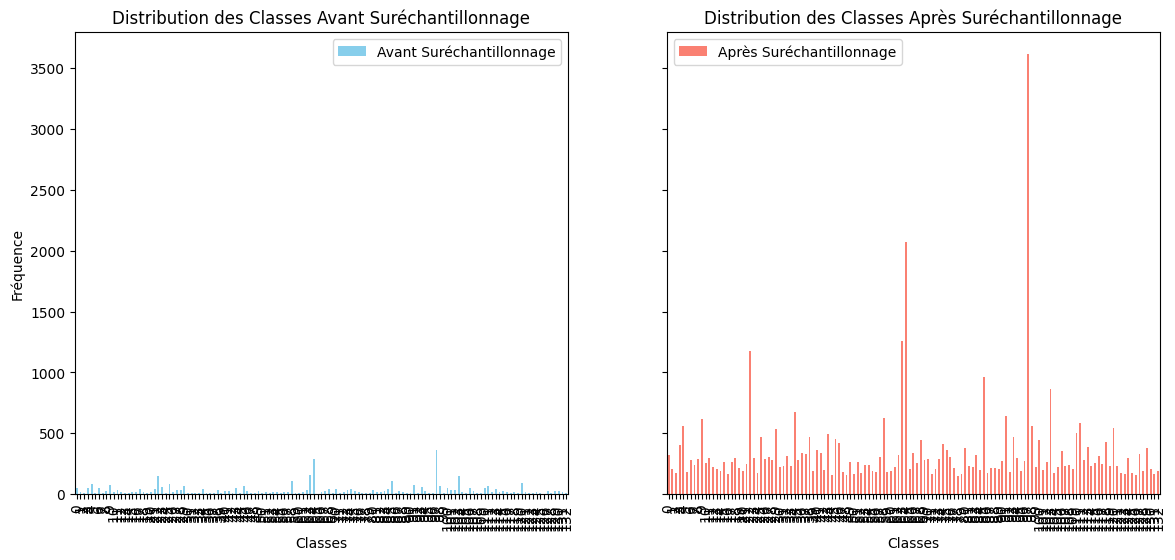

Total des mots: 387868, Mots couverts : 335053
Logistic Regression (OneVsRest)_Word2Vec__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.1342355175688509,
        "recall": 0.6432309442548351,
        "f1-score": 0.22211746218817524,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.11718149462645372,
        "recall": 0.5394851743954148,
        "f1-score": 0.18103121192910665,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.2209244082190332,
        "recall": 0.6432309442548351,
        "f1-score": 0.3086592080809824,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.16209108129232466,
        "recall": 0.5937166666666667,
        "f1-score": 0.23160815578585625,
        "support": 4395.0
    }
}
Jaccard Score: 0.15
Word Coverage: 0.86


2024/11/09 13:29:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression (OneVsRest)_Word2Vec'.
2024/11/09 13:29:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_Word2Vec, version 1
Created version '1' of model 'Logistic Regression (OneVsRest)_Word2Vec'.
2024/11/09 13:29:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_Word2Vec__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/90b51cccc4f84b3883bb38cf95c384ad.
2024/11/09 13:29:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_Word2Vec__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_Word2Vec'.


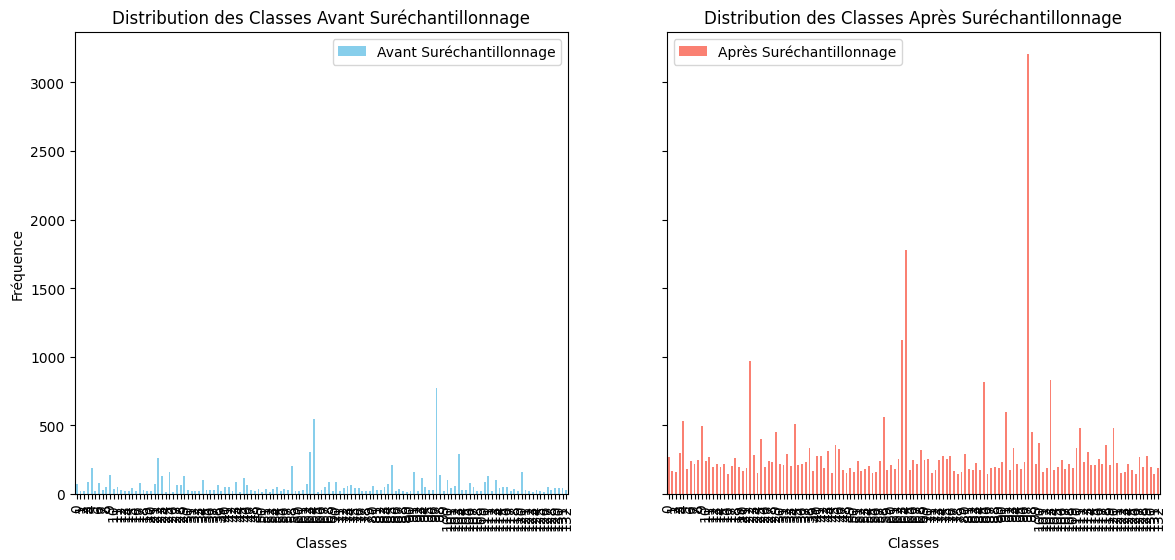

Total des mots: 406332, Mots couverts : 356528
Logistic Regression (OneVsRest)_Word2Vec__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.15079600514189656,
        "recall": 0.7039003000230787,
        "f1-score": 0.24838144875605683,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.13251715995375557,
        "recall": 0.6273326338274975,
        "f1-score": 0.208338591958433,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.2387424908290195,
        "recall": 0.7039003000230787,
        "f1-score": 0.33545934438649466,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.17050812757601783,
        "recall": 0.650025,
        "f1-score": 0.25092503824182655,
        "support": 4333.0
    }
}
Jaccard Score: 0.16
Word Coverage: 0.88


2024/11/09 13:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 13:29:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_Word2Vec, version 2
Created version '2' of model 'Logistic Regression (OneVsRest)_Word2Vec'.
2024/11/09 13:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_Word2Vec__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/133aa495851a4e498483afb64f7aeb07.
2024/11/09 13:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_Word2Vec__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_Word2Vec'.


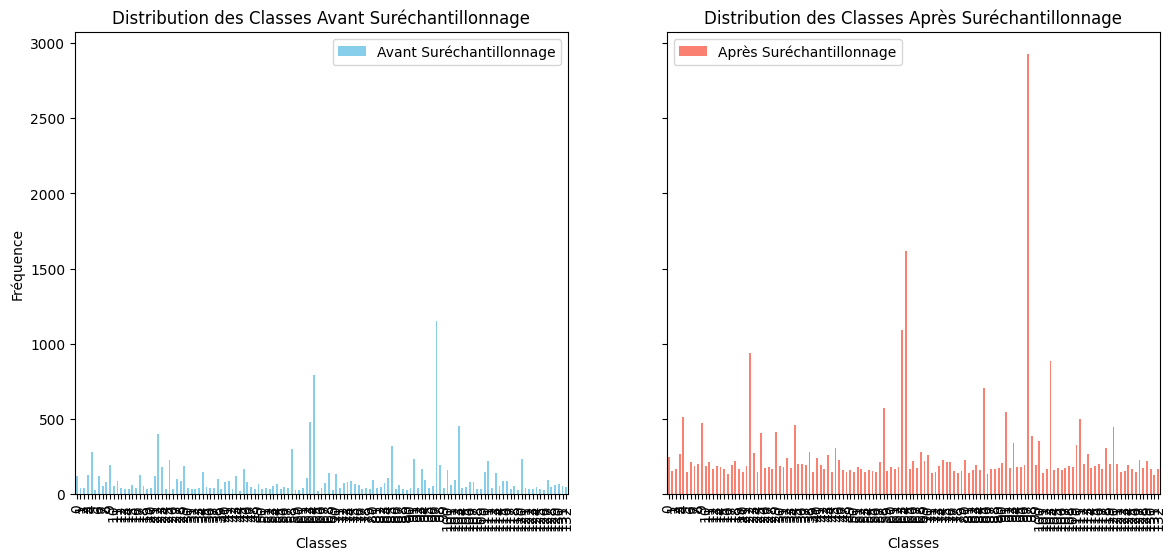

Total des mots: 417513, Mots couverts : 374262
Logistic Regression (OneVsRest)_Word2Vec__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.16359989972424166,
        "recall": 0.7623831775700934,
        "f1-score": 0.269391124871001,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.14044316303501633,
        "recall": 0.6947210805102018,
        "f1-score": 0.22359335420436438,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.25361483259791384,
        "recall": 0.7623831775700934,
        "f1-score": 0.3595485763285835,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.18936209226040707,
        "recall": 0.7082999999999999,
        "f1-score": 0.27745077299664334,
        "support": 4280.0
    }
}
Jaccard Score: 0.18
Word Coverage: 0.90


2024/11/09 13:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 13:30:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_Word2Vec, version 3
Created version '3' of model 'Logistic Regression (OneVsRest)_Word2Vec'.
2024/11/09 13:30:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_Word2Vec__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/431a4636c4e64c86a07fad9423a06971.
2024/11/09 13:30:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_Word2Vec__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_Word2Vec'.


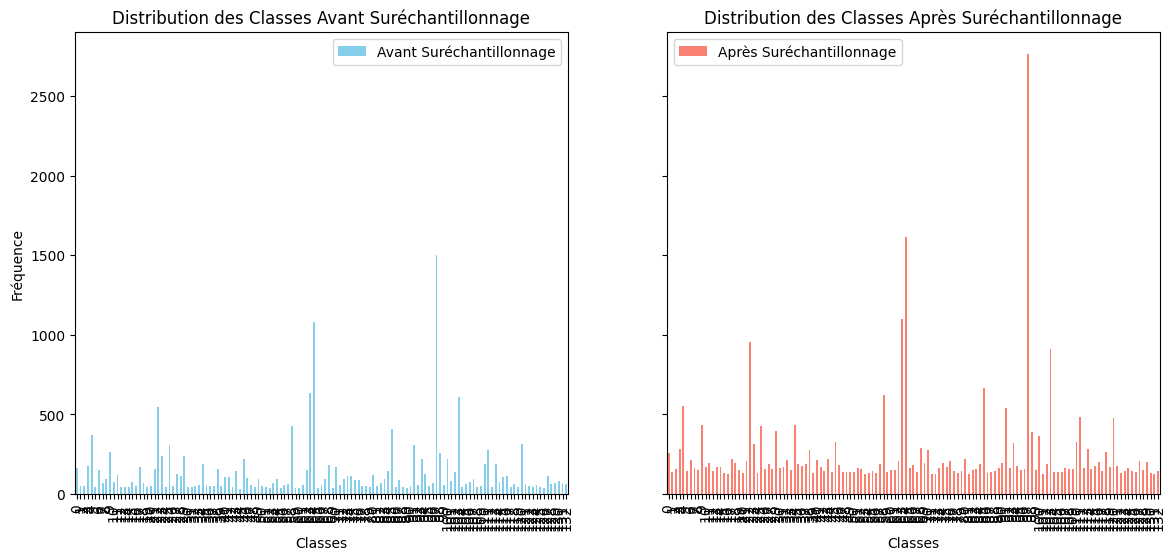

Total des mots: 413810, Mots couverts : 377202
Logistic Regression (OneVsRest)_Word2Vec__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.15940694801104704,
        "recall": 0.774482109227872,
        "f1-score": 0.2643950656969502,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.14153745330376805,
        "recall": 0.7112115659972005,
        "f1-score": 0.22548729740116025,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.25373841100661915,
        "recall": 0.774482109227872,
        "f1-score": 0.3594184361160725,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.18527581907442506,
        "recall": 0.7155750000000001,
        "f1-score": 0.27246095051522545,
        "support": 4248.0
    }
}
Jaccard Score: 0.17
Word Coverage: 0.91


2024/11/09 13:31:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 13:31:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_Word2Vec, version 4
Created version '4' of model 'Logistic Regression (OneVsRest)_Word2Vec'.
2024/11/09 13:31:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_Word2Vec__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/79a4b20dc5fc4b53967a695b3f8d5894.
2024/11/09 13:31:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_Word2Vec__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_Word2Vec'.


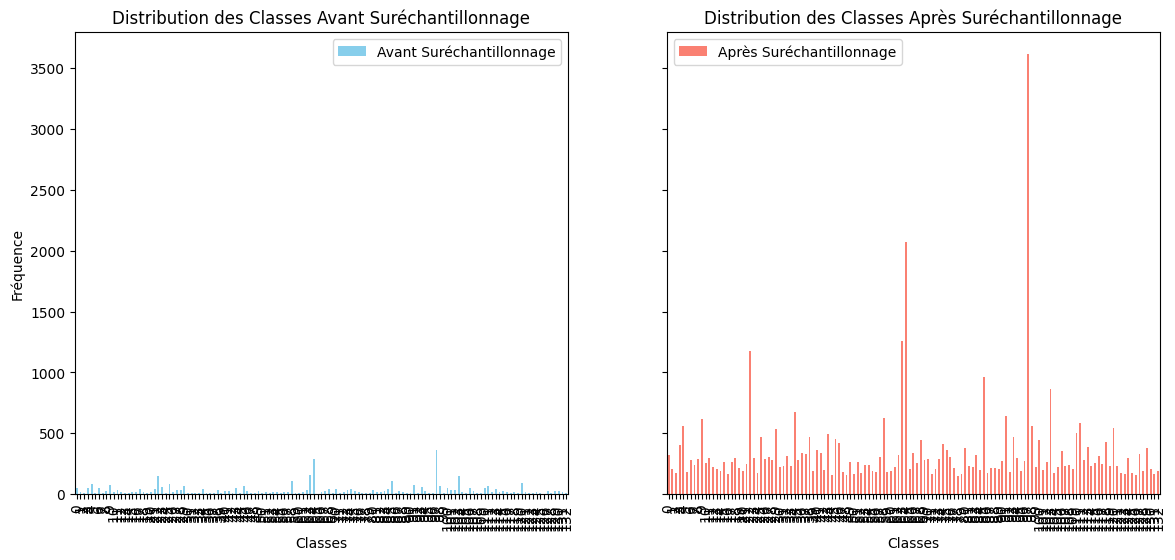

Logistic Regression (OneVsRest)_BERT__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.1628312966195842,
        "recall": 0.4668941979522184,
        "f1-score": 0.2414543743013473,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.15782389536071867,
        "recall": 0.3548236009292226,
        "f1-score": 0.2031503270430894,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.19825989042649877,
        "recall": 0.4668941979522184,
        "f1-score": 0.2673367529097733,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.1747601114571703,
        "recall": 0.43835833333333335,
        "f1-score": 0.22730493146774106,
        "support": 4395.0
    }
}
Jaccard Score: 0.15
Word Coverage: 0.73


2024/11/09 13:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression (OneVsRest)_BERT'.
2024/11/09 13:44:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_BERT, version 1
Created version '1' of model 'Logistic Regression (OneVsRest)_BERT'.
2024/11/09 13:44:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_BERT__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/f9758cf3da5947b7bb2ef3e9485a5908.
2024/11/09 13:44:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_BERT__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_BERT'.


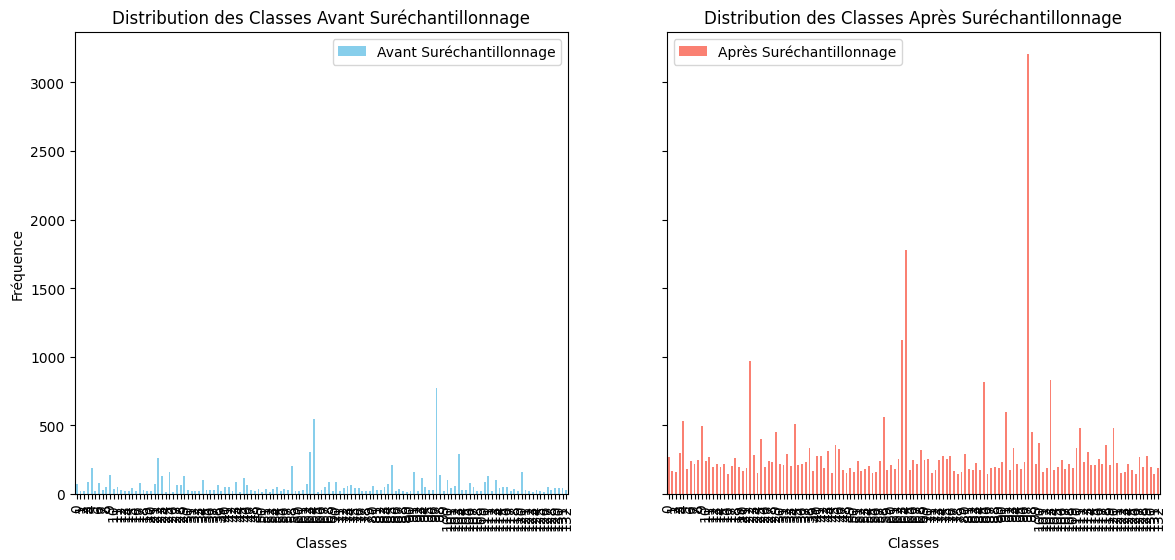

Logistic Regression (OneVsRest)_BERT__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.13698405765450972,
        "recall": 0.5790445418878375,
        "f1-score": 0.22155503554240805,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.13036644462806918,
        "recall": 0.47753489059414733,
        "f1-score": 0.19451355770597833,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.18182351486373485,
        "recall": 0.5790445418878375,
        "f1-score": 0.26674620436779295,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.14435322759136512,
        "recall": 0.5331333333333333,
        "f1-score": 0.21367858280460109,
        "support": 4333.0
    }
}
Jaccard Score: 0.13
Word Coverage: 0.73


2024/11/09 14:03:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 14:03:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_BERT, version 2
Created version '2' of model 'Logistic Regression (OneVsRest)_BERT'.
2024/11/09 14:03:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_BERT__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/2c849d9202604b9da8e85f3fba7bc371.
2024/11/09 14:03:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_BERT__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_BERT'.


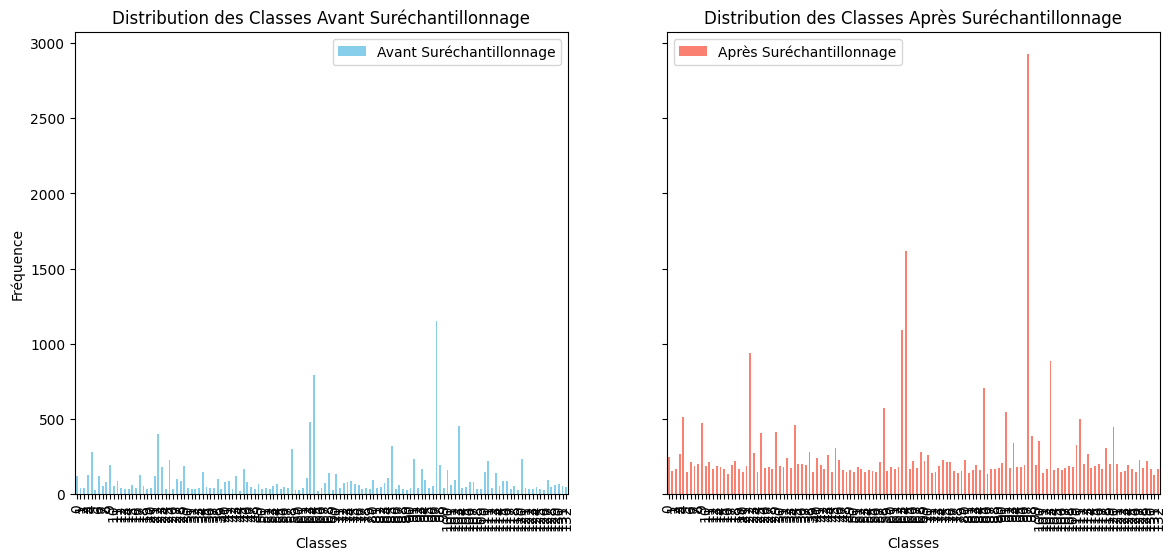

Logistic Regression (OneVsRest)_BERT__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.1259719367235678,
        "recall": 0.6586448598130841,
        "f1-score": 0.21149373546402583,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.11365989386192966,
        "recall": 0.5814893247659778,
        "f1-score": 0.1842796717066151,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.17374322370591638,
        "recall": 0.6586448598130841,
        "f1-score": 0.264539859024672,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.13383131382888055,
        "recall": 0.6109833333333333,
        "f1-score": 0.20850540407421753,
        "support": 4280.0
    }
}
Jaccard Score: 0.13
Word Coverage: 0.72


2024/11/09 14:28:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 14:28:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_BERT, version 3
Created version '3' of model 'Logistic Regression (OneVsRest)_BERT'.
2024/11/09 14:28:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_BERT__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/1dbce11f149a48179eeb16d5dd3f23fb.
2024/11/09 14:28:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_BERT__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_BERT'.


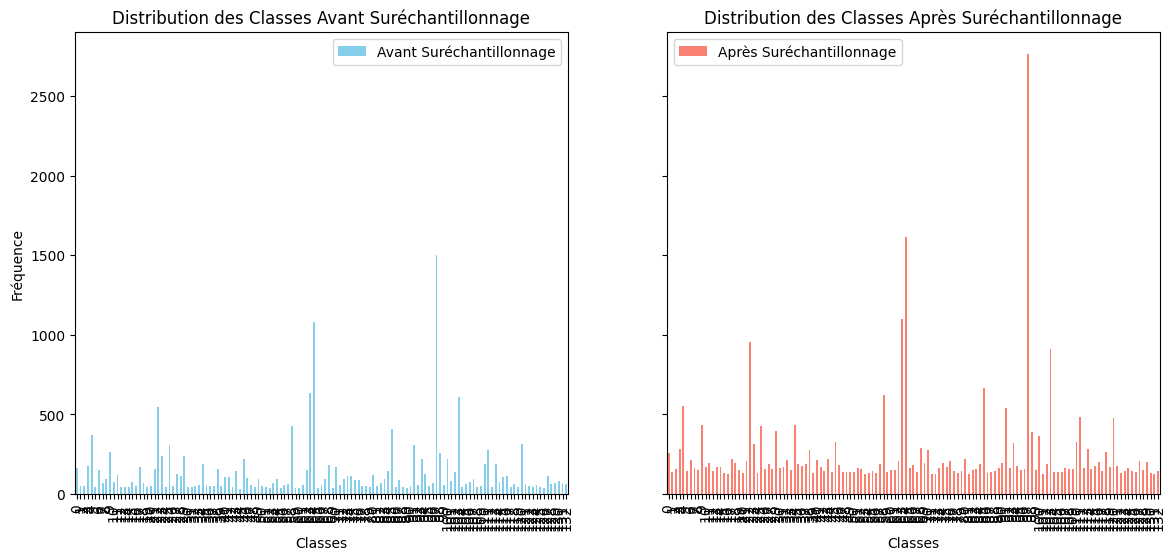

Logistic Regression (OneVsRest)_BERT__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.11501956378568938,
        "recall": 0.6989171374764596,
        "f1-score": 0.1975316855726689,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.10379024553277849,
        "recall": 0.6252490891638103,
        "f1-score": 0.17238562848704236,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.16805358490034714,
        "recall": 0.6989171374764596,
        "f1-score": 0.25872118724324,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.12324210758944101,
        "recall": 0.6475,
        "f1-score": 0.1973163627007995,
        "support": 4248.0
    }
}
Jaccard Score: 0.12
Word Coverage: 0.73


2024/11/09 15:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 15:00:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_BERT, version 4
Created version '4' of model 'Logistic Regression (OneVsRest)_BERT'.
2024/11/09 15:00:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_BERT__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/f2c2a1aa64c54760b521b565585aa814.
2024/11/09 15:00:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_BERT__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_BERT'.


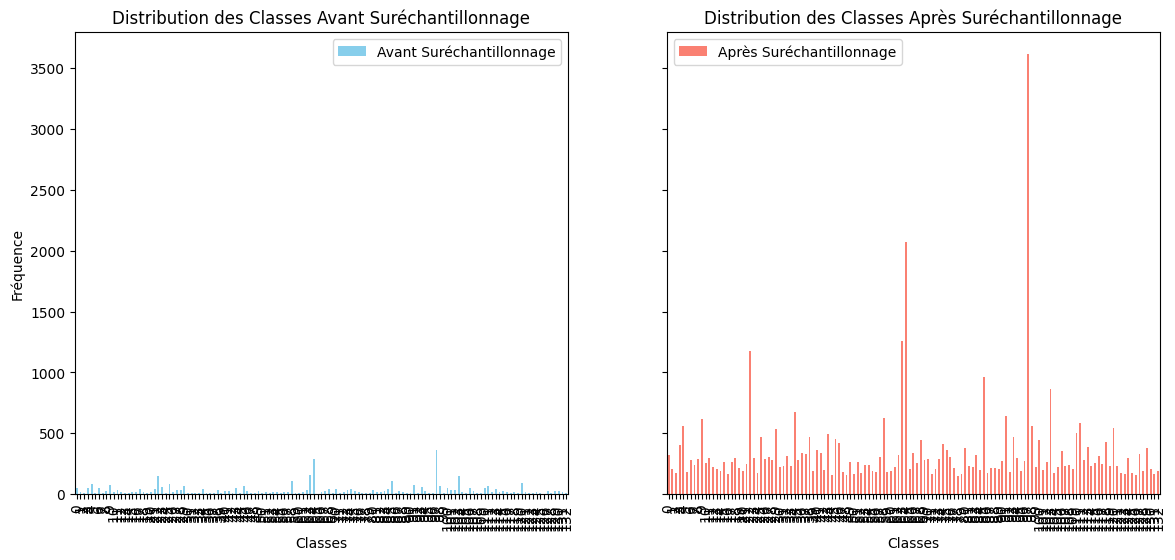

Logistic Regression (OneVsRest)_USE__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.2702923551843109,
        "recall": 0.6773606370875995,
        "f1-score": 0.3863975598676098,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.2570841399894071,
        "recall": 0.5862852985541869,
        "f1-score": 0.3389845767769221,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.3357473284774507,
        "recall": 0.6773606370875995,
        "f1-score": 0.433651425125293,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.28025047521922525,
        "recall": 0.6347249999999999,
        "f1-score": 0.3629665786011374,
        "support": 4395.0
    }
}
Jaccard Score: 0.25
Word Coverage: 0.00


2024/11/09 15:01:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression (OneVsRest)_USE'.
2024/11/09 15:01:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_USE, version 1
Created version '1' of model 'Logistic Regression (OneVsRest)_USE'.
2024/11/09 15:01:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_USE__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/84a74e3e9ded446691dfddc945e39a4b.
2024/11/09 15:01:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_USE__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_USE'.


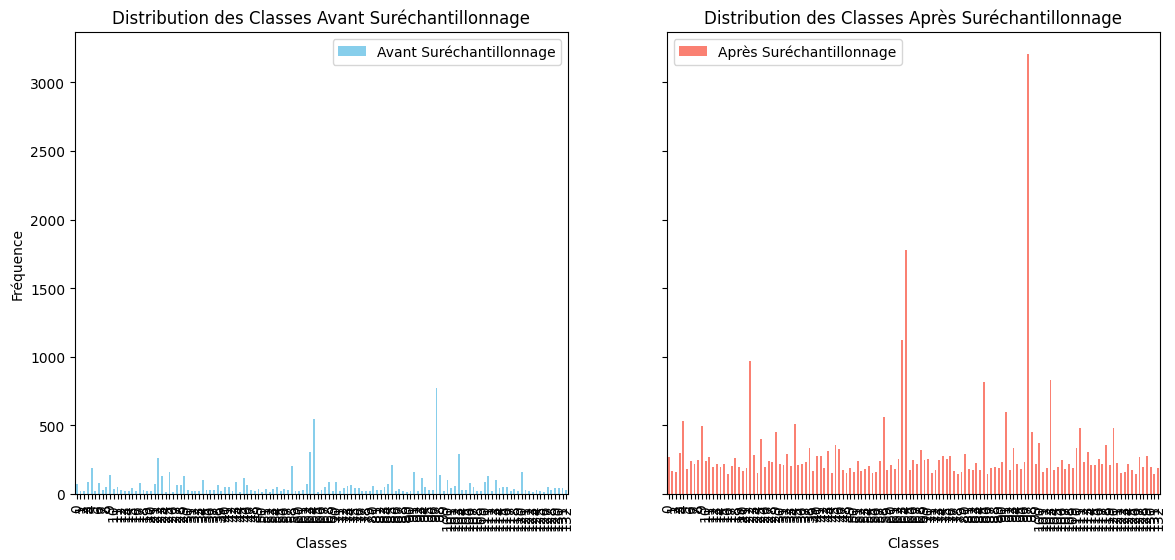

Logistic Regression (OneVsRest)_USE__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.2110972322661232,
        "recall": 0.7410570043849527,
        "f1-score": 0.3285918952108064,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.1920209030209855,
        "recall": 0.6750793718080695,
        "f1-score": 0.28641626122528624,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.2886241902269135,
        "recall": 0.7410570043849527,
        "f1-score": 0.39791558229390694,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.21975962498328985,
        "recall": 0.6902166666666666,
        "f1-score": 0.3157517204899541,
        "support": 4333.0
    }
}
Jaccard Score: 0.21
Word Coverage: 0.00


2024/11/09 15:02:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 15:02:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_USE, version 2
Created version '2' of model 'Logistic Regression (OneVsRest)_USE'.
2024/11/09 15:02:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_USE__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/87d53b2eb2594812bb05c53acb1acce7.
2024/11/09 15:02:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_USE__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_USE'.


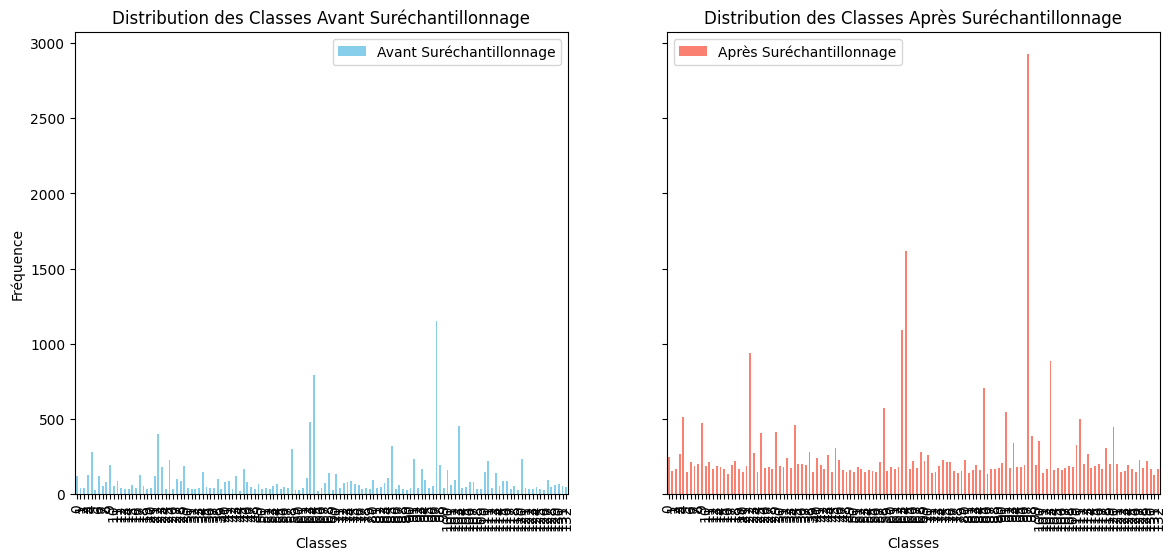

Logistic Regression (OneVsRest)_USE__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.18816079295154184,
        "recall": 0.7983644859813084,
        "f1-score": 0.3045454545454545,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.1685052002279263,
        "recall": 0.752528302726036,
        "f1-score": 0.26451493723529873,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.27157301763205516,
        "recall": 0.7983644859813084,
        "f1-score": 0.3853328139044299,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.19605370881044593,
        "recall": 0.7411,
        "f1-score": 0.29606087070196374,
        "support": 4280.0
    }
}
Jaccard Score: 0.19
Word Coverage: 0.00


2024/11/09 15:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 15:02:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_USE, version 3
Created version '3' of model 'Logistic Regression (OneVsRest)_USE'.
2024/11/09 15:02:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_USE__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/6cf56f05799c43389206f69fd04bbba8.
2024/11/09 15:02:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_USE__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_USE'.


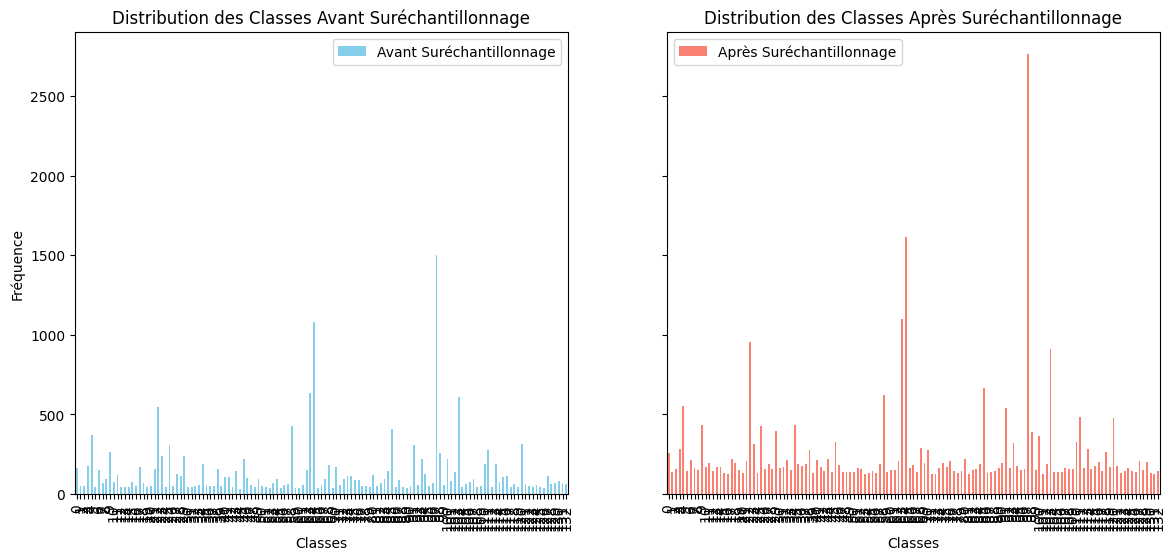

Logistic Regression (OneVsRest)_USE__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.1731774686790964,
        "recall": 0.8265065913370998,
        "f1-score": 0.28635510969741457,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.15814289261406628,
        "recall": 0.7764684120896426,
        "f1-score": 0.2520940415784644,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.26279628559674334,
        "recall": 0.8265065913370998,
        "f1-score": 0.37661951984441366,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.18267345281483371,
        "recall": 0.7705916666666667,
        "f1-score": 0.28204975802371746,
        "support": 4248.0
    }
}
Jaccard Score: 0.18
Word Coverage: 0.00


2024/11/09 15:03:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 15:03:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_USE, version 4
Created version '4' of model 'Logistic Regression (OneVsRest)_USE'.
2024/11/09 15:03:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression (OneVsRest)_USE__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/2fc6da781a564315a27d55a503dc5b13.
2024/11/09 15:03:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'Logistic Regression (OneVsRest)_USE__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_USE'.


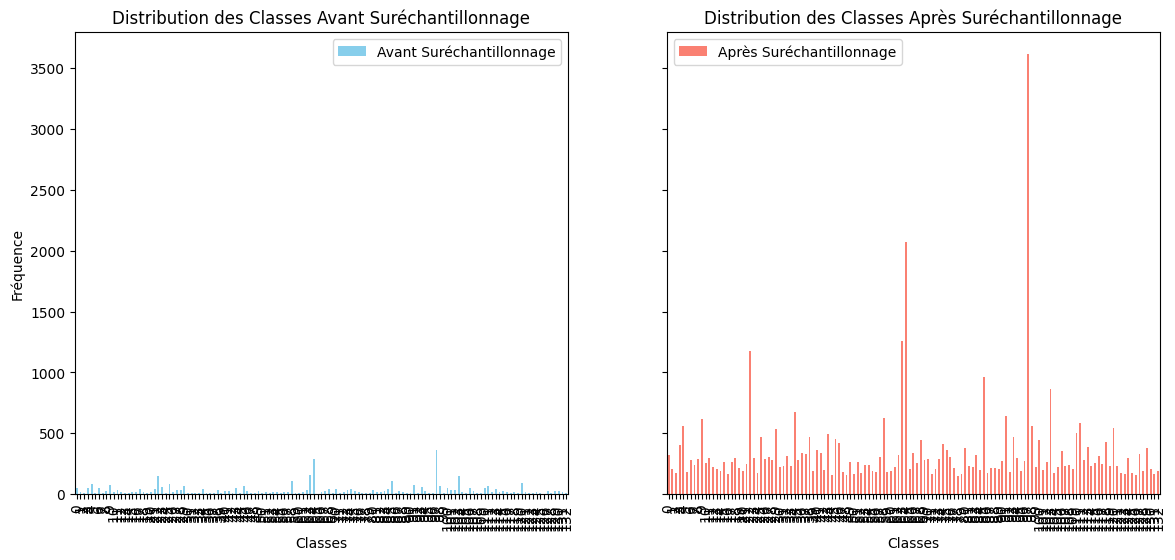

Total des mots: 387868, Mots couverts : 335053
SGDClassifier (OneVsRest)_Word2Vec__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.12490725788853489,
        "recall": 0.6511945392491467,
        "f1-score": 0.20960890581514574,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.11153126275404111,
        "recall": 0.5494283030928431,
        "f1-score": 0.17355647311512307,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.2102448836700361,
        "recall": 0.6511945392491467,
        "f1-score": 0.29764555162228373,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.1488570644836441,
        "recall": 0.5976583333333333,
        "f1-score": 0.2192741859762313,
        "support": 4395.0
    }
}
Jaccard Score: 0.14
Word Coverage: 0.86


2024/11/09 15:03:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SGDClassifier (OneVsRest)_Word2Vec'.
2024/11/09 15:03:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_Word2Vec, version 1
Created version '1' of model 'SGDClassifier (OneVsRest)_Word2Vec'.
2024/11/09 15:03:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_Word2Vec__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/cd79c8172fe14589b2539db913acde90.
2024/11/09 15:03:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_Word2Vec__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_Word2Vec'.


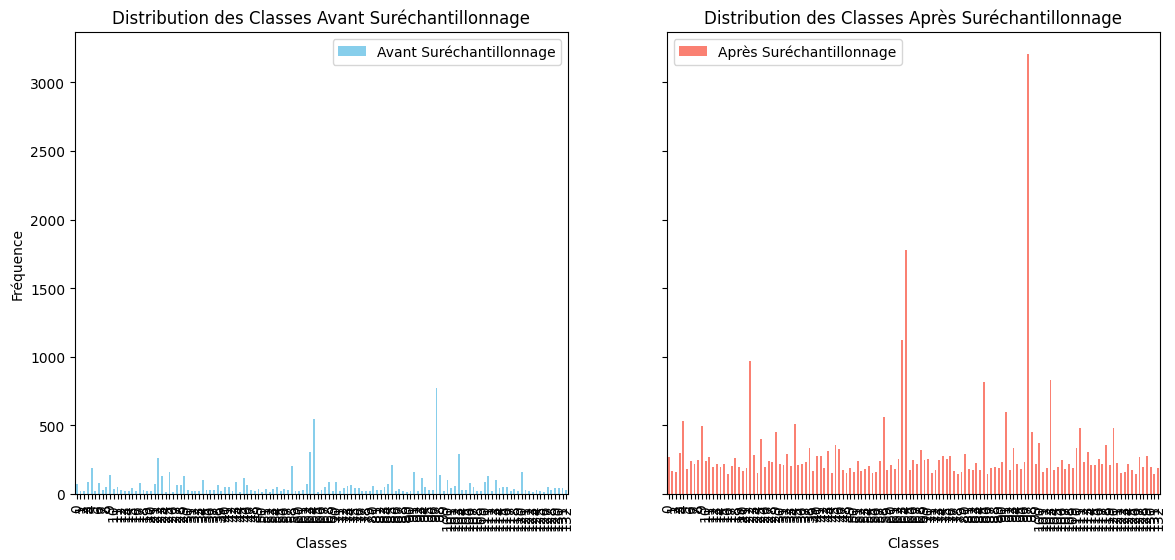

Total des mots: 406332, Mots couverts : 356528
SGDClassifier (OneVsRest)_Word2Vec__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.1411277180239326,
        "recall": 0.6995153473344103,
        "f1-score": 0.2348702053467648,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.1291629148252545,
        "recall": 0.6204846452968807,
        "f1-score": 0.20230384040944677,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.23079973676579194,
        "recall": 0.6995153473344103,
        "f1-score": 0.3261501655502832,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.1568939002574678,
        "recall": 0.6442,
        "f1-score": 0.23654225738309712,
        "support": 4333.0
    }
}
Jaccard Score: 0.15
Word Coverage: 0.88


2024/11/09 15:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 15:04:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_Word2Vec, version 2
Created version '2' of model 'SGDClassifier (OneVsRest)_Word2Vec'.
2024/11/09 15:04:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_Word2Vec__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/01baa3e40a9d437186fdda82619c94b1.
2024/11/09 15:04:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_Word2Vec__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_Word2Vec'.


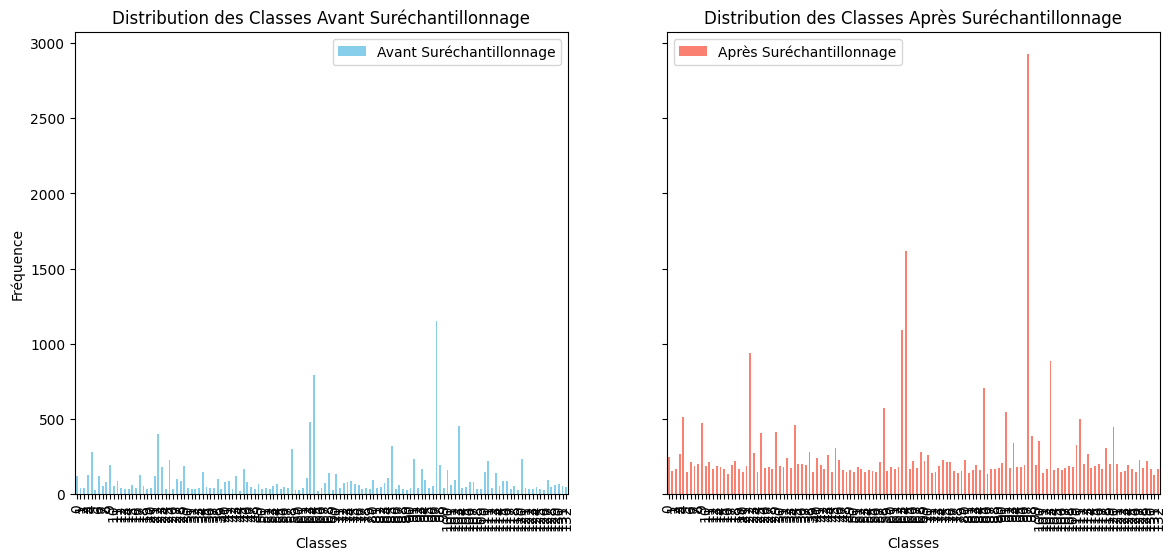

Total des mots: 417513, Mots couverts : 374262
SGDClassifier (OneVsRest)_Word2Vec__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.15004195021907338,
        "recall": 0.7521028037383177,
        "f1-score": 0.25017486593611565,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.13611441082705356,
        "recall": 0.6837742133903616,
        "f1-score": 0.2153118181085542,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.24513220624840174,
        "recall": 0.7521028037383177,
        "f1-score": 0.3467705670256,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.17197994568118008,
        "recall": 0.6960916666666667,
        "f1-score": 0.25743162093582805,
        "support": 4280.0
    }
}
Jaccard Score: 0.16
Word Coverage: 0.90


2024/11/09 15:04:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 15:04:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_Word2Vec, version 3
Created version '3' of model 'SGDClassifier (OneVsRest)_Word2Vec'.
2024/11/09 15:04:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_Word2Vec__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/4ed5a058211c4ff3ab516f834e59eca1.
2024/11/09 15:04:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_Word2Vec__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_Word2Vec'.


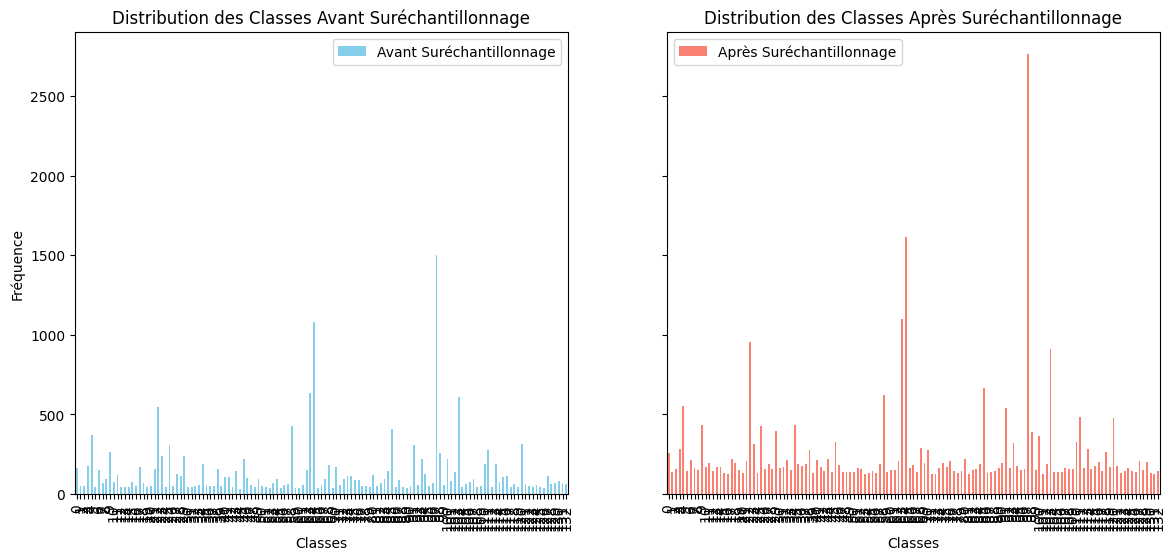

Total des mots: 413810, Mots couverts : 377202
SGDClassifier (OneVsRest)_Word2Vec__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.14049905676556337,
        "recall": 0.771421845574388,
        "f1-score": 0.23770491803278687,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.13635395003209166,
        "recall": 0.7108156031192046,
        "f1-score": 0.2160824128823768,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.24584692498712804,
        "recall": 0.771421845574388,
        "f1-score": 0.346890338205535,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.15822153437858838,
        "recall": 0.7142333333333334,
        "f1-score": 0.24366349966338494,
        "support": 4248.0
    }
}
Jaccard Score: 0.15
Word Coverage: 0.91


2024/11/09 15:05:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_Word2Vec' already exists. Creating a new version of this model...
2024/11/09 15:05:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_Word2Vec, version 4
Created version '4' of model 'SGDClassifier (OneVsRest)_Word2Vec'.
2024/11/09 15:05:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_Word2Vec__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/c073c6fb26384f10bb0f4b7525dcfe45.
2024/11/09 15:05:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_Word2Vec__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_Word2Vec'.


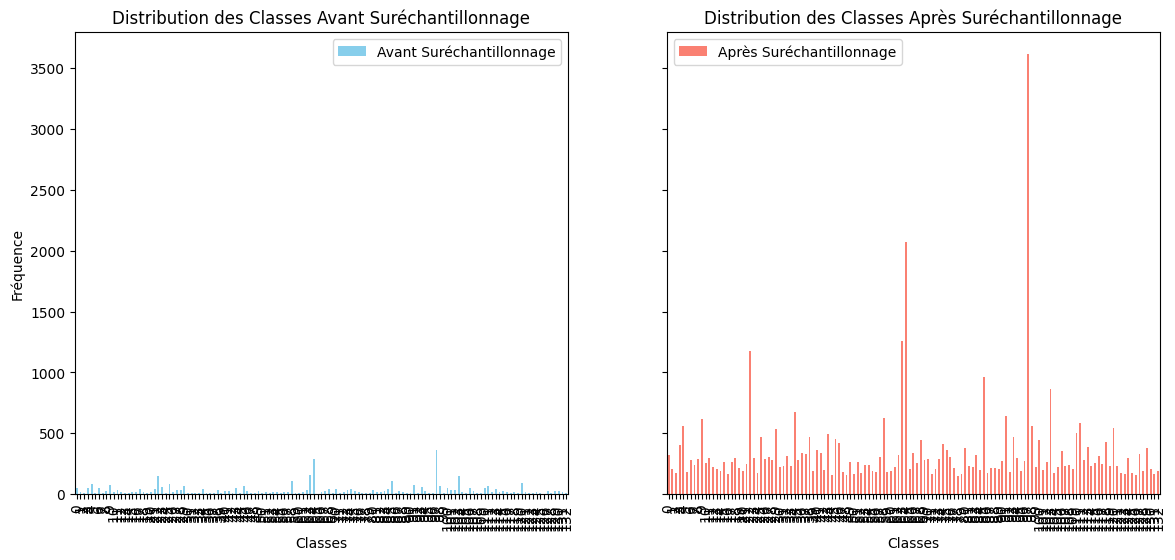

SGDClassifier (OneVsRest)_BERT__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.16759584870057467,
        "recall": 0.4445961319681456,
        "f1-score": 0.2434284290519497,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.16560792725895795,
        "recall": 0.29323195272589936,
        "f1-score": 0.18325373198185133,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.20108754905640217,
        "recall": 0.4445961319681456,
        "f1-score": 0.2574530579943429,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.17853594701866762,
        "recall": 0.41725,
        "f1-score": 0.22697459823458274,
        "support": 4395.0
    }
}
Jaccard Score: 0.15
Word Coverage: 0.73


2024/11/09 15:18:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SGDClassifier (OneVsRest)_BERT'.
2024/11/09 15:18:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_BERT, version 1
Created version '1' of model 'SGDClassifier (OneVsRest)_BERT'.
2024/11/09 15:18:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_BERT__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/74b5bcdb7e5d4b88911a226190dcff55.
2024/11/09 15:18:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_BERT__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_BERT'.


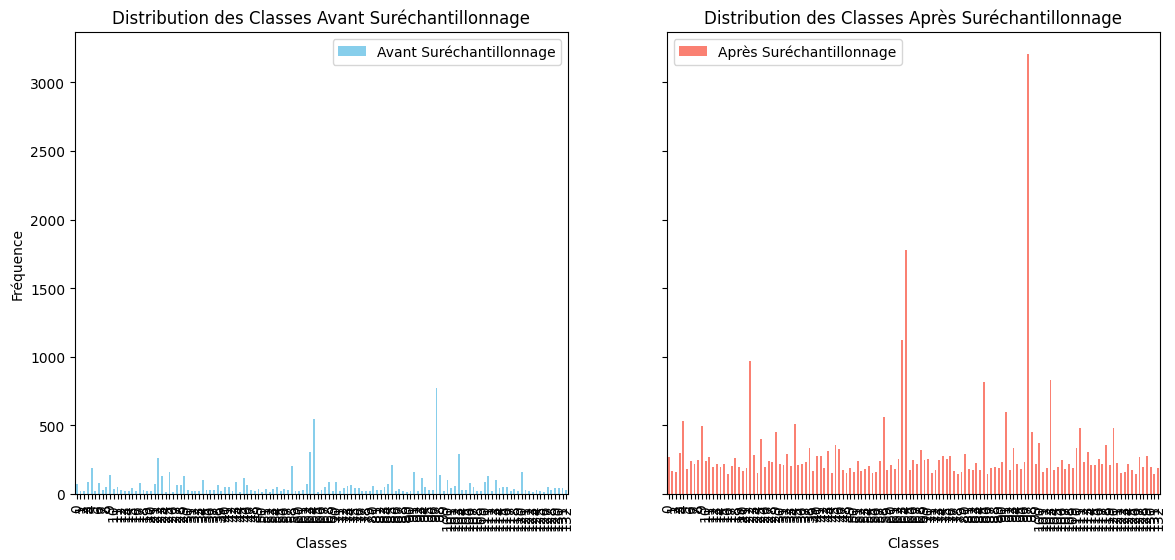

SGDClassifier (OneVsRest)_BERT__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.1378441907320349,
        "recall": 0.5684283406415878,
        "f1-score": 0.2218818972118373,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.14310010644352622,
        "recall": 0.4429875175394798,
        "f1-score": 0.19878575926041536,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.18410267188206553,
        "recall": 0.5684283406415878,
        "f1-score": 0.2650697357594904,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.14411312822125752,
        "recall": 0.5230499999999999,
        "f1-score": 0.2127281811237787,
        "support": 4333.0
    }
}
Jaccard Score: 0.13
Word Coverage: 0.73


2024/11/09 15:37:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 15:37:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_BERT, version 2
Created version '2' of model 'SGDClassifier (OneVsRest)_BERT'.
2024/11/09 15:37:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_BERT__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/1f9cc3f85d2b49909fa4312ad54203eb.
2024/11/09 15:37:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_BERT__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_BERT'.


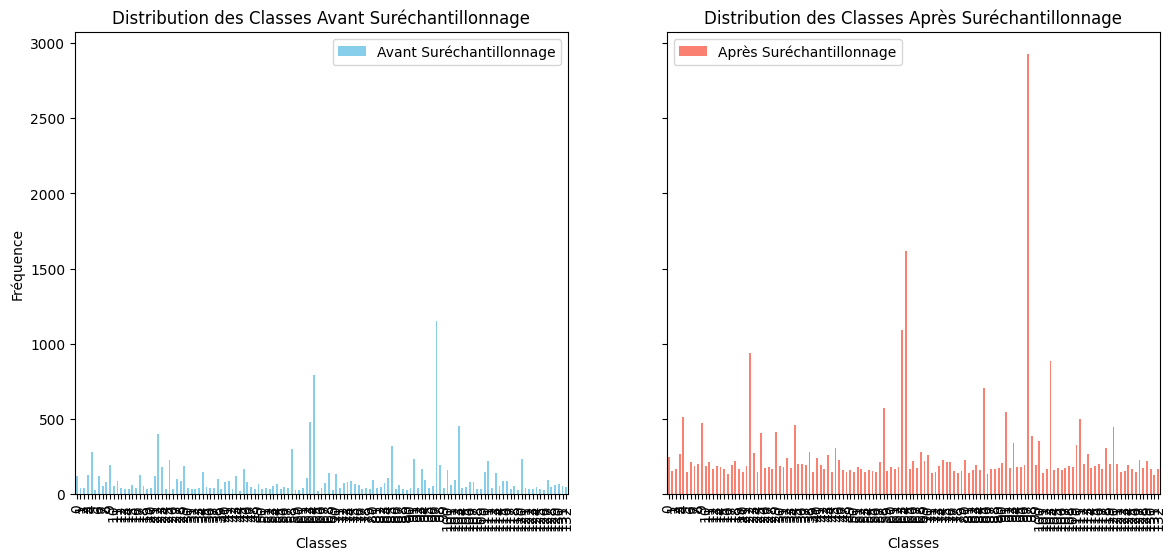

SGDClassifier (OneVsRest)_BERT__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.11859562305362399,
        "recall": 0.6495327102803738,
        "f1-score": 0.2005699650084773,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.12043933054437199,
        "recall": 0.5598088209523694,
        "f1-score": 0.18820488321608855,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.17103211116073566,
        "recall": 0.6495327102803738,
        "f1-score": 0.2593569307378177,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.12619312435976818,
        "recall": 0.6033416666666667,
        "f1-score": 0.19832950786111977,
        "support": 4280.0
    }
}
Jaccard Score: 0.12
Word Coverage: 0.72


2024/11/09 16:02:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 16:02:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_BERT, version 3
Created version '3' of model 'SGDClassifier (OneVsRest)_BERT'.
2024/11/09 16:02:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_BERT__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/5b4f4beb5f5746d0a770d91856e10e34.
2024/11/09 16:02:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_BERT__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_BERT'.


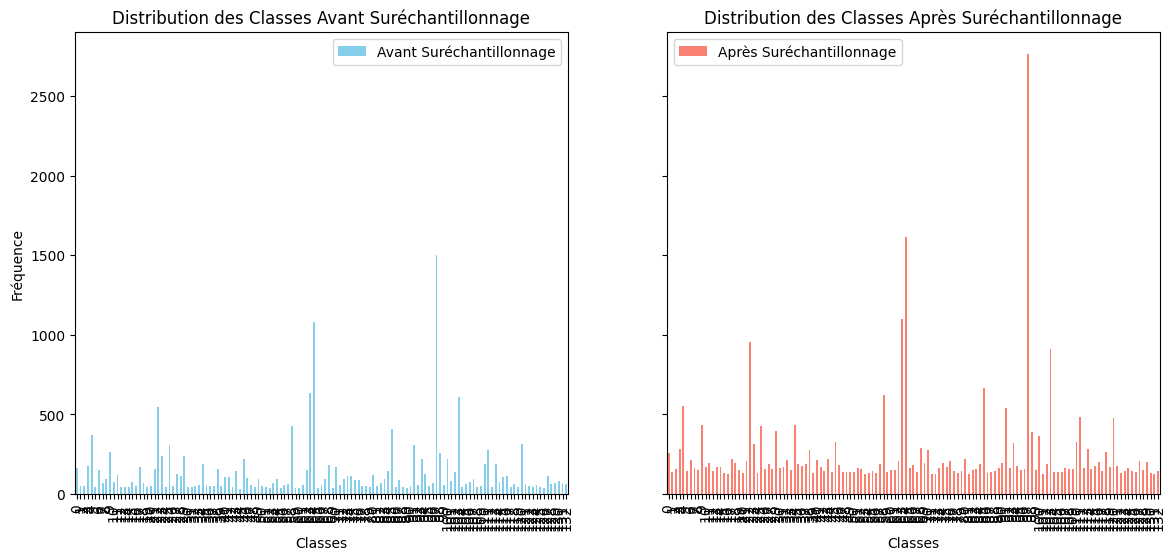

SGDClassifier (OneVsRest)_BERT__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.10470001077160605,
        "recall": 0.6864406779661016,
        "f1-score": 0.18168790304993926,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.10405628220453918,
        "recall": 0.6006320112555098,
        "f1-score": 0.16898659437169755,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.16138479766724093,
        "recall": 0.6864406779661016,
        "f1-score": 0.24804057186347567,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.11103059029176914,
        "recall": 0.638525,
        "f1-score": 0.18138038785165048,
        "support": 4248.0
    }
}
Jaccard Score: 0.11
Word Coverage: 0.73


2024/11/09 16:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_BERT' already exists. Creating a new version of this model...
2024/11/09 16:33:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_BERT, version 4
Created version '4' of model 'SGDClassifier (OneVsRest)_BERT'.
2024/11/09 16:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_BERT__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/004a80cf26744f0db71f3b3222864a59.
2024/11/09 16:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_BERT__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_BERT'.


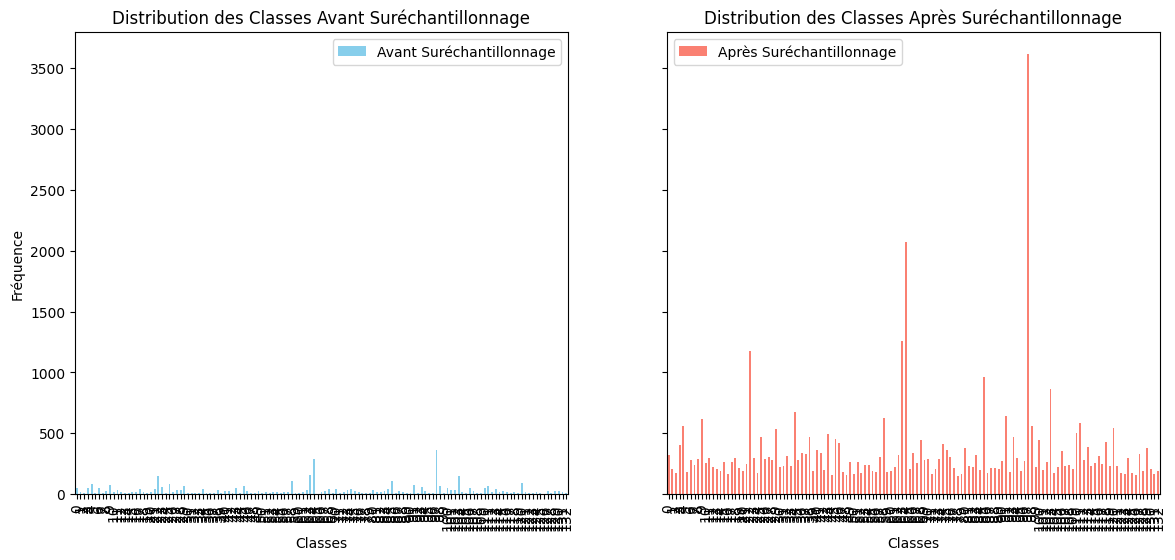

SGDClassifier (OneVsRest)_USE__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.2507408626934475,
        "recall": 0.6930602957906712,
        "f1-score": 0.36825243305325517,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.2430966523449488,
        "recall": 0.6070367360525463,
        "f1-score": 0.3284348535892789,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.32679490666553307,
        "recall": 0.6930602957906712,
        "f1-score": 0.4262562650730724,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.2594492243867244,
        "recall": 0.6499333333333334,
        "f1-score": 0.34834188784641573,
        "support": 4395.0
    }
}
Jaccard Score: 0.24
Word Coverage: 0.00


2024/11/09 16:33:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SGDClassifier (OneVsRest)_USE'.
2024/11/09 16:33:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_USE, version 1
Created version '1' of model 'SGDClassifier (OneVsRest)_USE'.
2024/11/09 16:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_USE__temporal_split_0 at: http://127.0.0.1:5000/#/experiments/0/runs/bc9dc0e6a5674a2b914287a48912ce7c.
2024/11/09 16:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_USE__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_USE'.


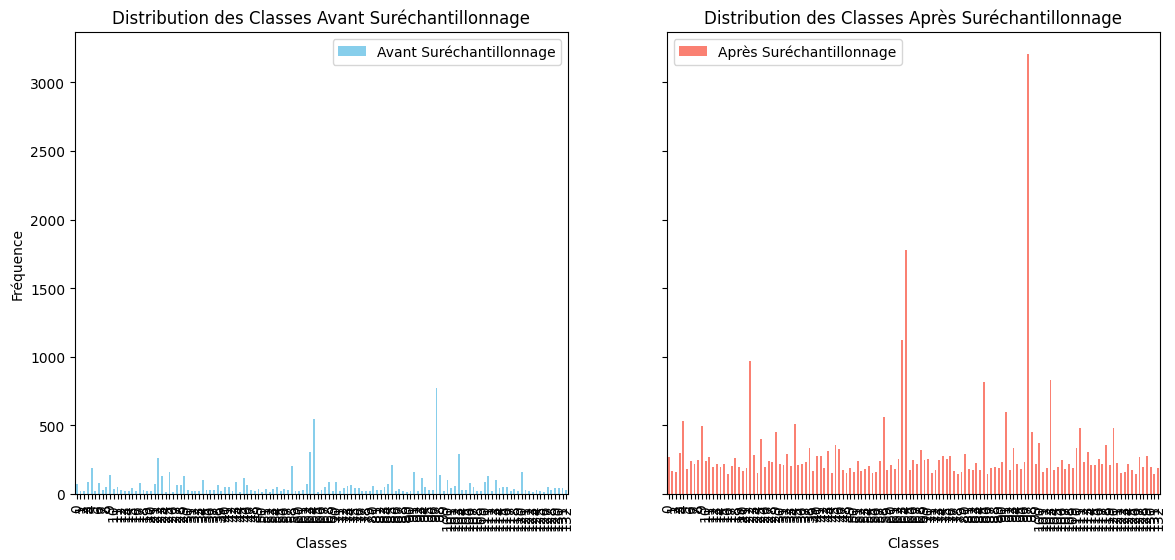

SGDClassifier (OneVsRest)_USE__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.2037060222862151,
        "recall": 0.7509808446803601,
        "f1-score": 0.32048062244546216,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.18657060058841785,
        "recall": 0.6899429630601511,
        "f1-score": 0.2799491730490161,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.2846565662336286,
        "recall": 0.7509808446803601,
        "f1-score": 0.3940791268627887,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.21087605387603453,
        "recall": 0.6956916666666666,
        "f1-score": 0.30746472685512094,
        "support": 4333.0
    }
}
Jaccard Score: 0.20
Word Coverage: 0.00


2024/11/09 16:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 16:34:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_USE, version 2
Created version '2' of model 'SGDClassifier (OneVsRest)_USE'.
2024/11/09 16:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_USE__temporal_split_1 at: http://127.0.0.1:5000/#/experiments/0/runs/ed96520aa7d0462f97ff37f8cfdc7de9.
2024/11/09 16:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_USE__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_USE'.


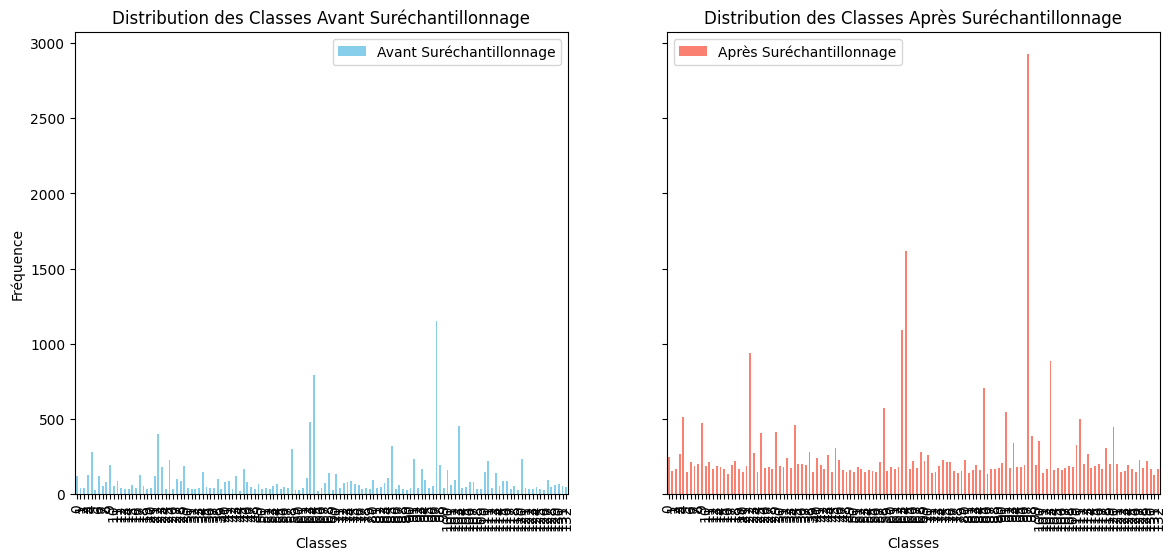

SGDClassifier (OneVsRest)_USE__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.182685607075851,
        "recall": 0.7962616822429907,
        "f1-score": 0.29718770438194897,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.1665793024351506,
        "recall": 0.7564145060151681,
        "f1-score": 0.2594856153670353,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.27562706085701044,
        "recall": 0.7962616822429907,
        "f1-score": 0.38638854872030404,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.1873701465437727,
        "recall": 0.7390833333333332,
        "f1-score": 0.2864959425875969,
        "support": 4280.0
    }
}
Jaccard Score: 0.18
Word Coverage: 0.00


2024/11/09 16:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 16:34:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_USE, version 3
Created version '3' of model 'SGDClassifier (OneVsRest)_USE'.
2024/11/09 16:34:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_USE__temporal_split_2 at: http://127.0.0.1:5000/#/experiments/0/runs/69da46b5079e4c44a493a4972fdfc219.
2024/11/09 16:34:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_USE__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_USE'.


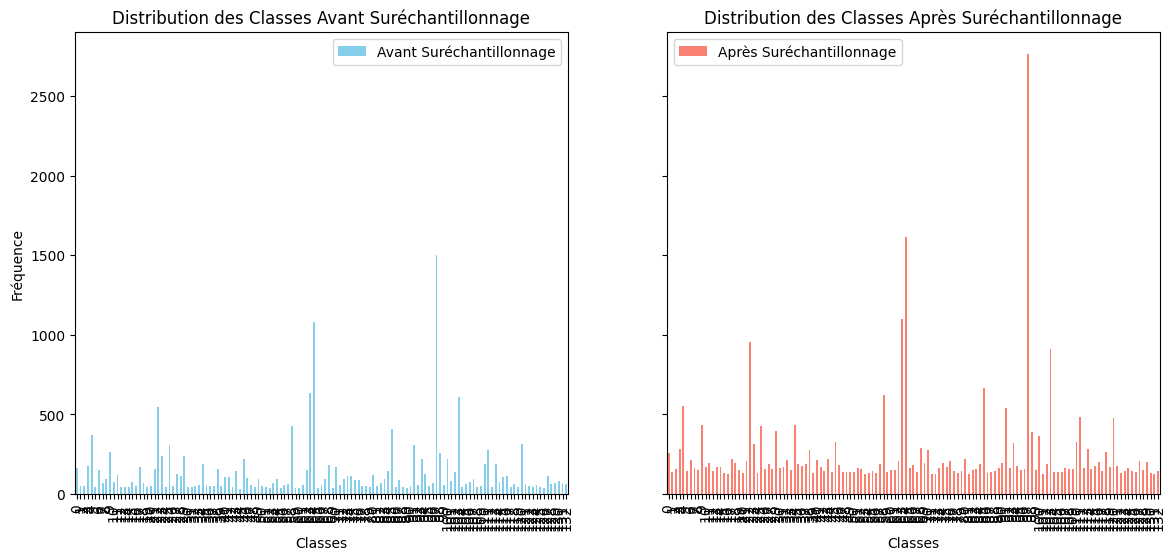

SGDClassifier (OneVsRest)_USE__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.16368894901338807,
        "recall": 0.8260357815442562,
        "f1-score": 0.27323340471092084,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.1532970294275297,
        "recall": 0.7825956243544199,
        "f1-score": 0.2447346759696308,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.26205205850233393,
        "recall": 0.8260357815442562,
        "f1-score": 0.3724185162724938,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.17145727285616152,
        "recall": 0.7685083333333333,
        "f1-score": 0.2684882966772625,
        "support": 4248.0
    }
}
Jaccard Score: 0.17
Word Coverage: 0.00


2024/11/09 16:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SGDClassifier (OneVsRest)_USE' already exists. Creating a new version of this model...
2024/11/09 16:35:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_USE, version 4
Created version '4' of model 'SGDClassifier (OneVsRest)_USE'.
2024/11/09 16:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run SGDClassifier (OneVsRest)_USE__temporal_split_3 at: http://127.0.0.1:5000/#/experiments/0/runs/68f859c416604993aa96dbab3407cd3c.
2024/11/09 16:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Le modèle 'SGDClassifier (OneVsRest)_USE__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_USE'.


[]

In [32]:
# Word2Vec + Logistic Regression
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_w2v, logistic_regression_model, params_w2v_lr)

# BERT + Logistic Regression
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_bert, logistic_regression_model, params_bert_lr)

# USE + Logistic Regression
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_use, logistic_regression_model, params_use_lr)

# Word2Vec + SGDClassifier
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_w2v, sgd_classifier_model, params_w2v_sgd)

# BERT + SGDClassifier
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_bert, sgd_classifier_model, params_bert_sgd)

# USE + SGDClassifier
temporal_evaluation(df_reduit, df_tags_reduit, vectorize_use, sgd_classifier_model, params_use_sgd)

In [33]:
def load_model_and_vectorizer(model_path, vectorizer_path):
    """
    Charge le modèle et le vectoriseur sauvegardés avec joblib.
    
    Parameters:
        model_path (str): Chemin du fichier du modèle.
        vectorizer_path (str): Chemin du fichier du vectoriseur.
    
    Returns:
        model, vectorizer: Le modèle et le vectoriseur chargés.
    """
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    return model, vectorizer

In [34]:
def predict_tags_for_question(question, model, vectorizer, pca, mlb, threshold=0.5):
    # Vectoriser la question
    question_vect = vectorizer.transform([question])
    
    # Appliquer la réduction de dimension avec PCA
    question_vect = pca.transform(question_vect.toarray())
    
    # Prédire les probabilités pour chaque classe (tag)
    y_pred_proba = model.predict_proba(question_vect)[0]
    
    # Appliquer le seuil pour sélectionner les tags
    predicted_indices = np.where(y_pred_proba >= threshold)[0]
    
    # Si aucun tag ne dépasse le seuil, on choisit les 5 meilleures probabilités
    if len(predicted_indices) == 0:
        predicted_indices = np.argsort(y_pred_proba)[-5:]
    
    # Récupérer les noms des tags prédits
    tags = mlb.classes_[predicted_indices]
    return tags

In [62]:
# # Charger le modèle, le vectoriseur et le binariseur
# model_path = "logistic-regression-onevsrest-word2vec-temporal-split-0_model.pkl"  # Remplacez par le chemin de votre modèle
# vectorizer_path = "logistic-regression-onevsrest-word2vec-temporal-split-0_vectorizer.pkl"  # Remplacez par le chemin de votre vectoriseur
# pca_path = "logistic-regression-onevsrest-word2vec__temporal_split_0_pca.pkl"
# mlb_path = "logistic-regression-onevsrest-word2vec-temporal-split-0_mlb.pkl"  # Remplacez par le chemin du MultiLabelBinarizer

# model, vectorizer = load_model_and_vectorizer(model_path, vectorizer_path)
# pca = joblib.load(pca_path)
# mlb = joblib.load(mlb_path)

In [66]:
# # Utiliser une question en dur
# question = "How to integrate my css file into my project ?"
# predicted_tags = predict_tags_for_question(question, model, vectorizer, pca, mlb)

In [37]:
# # Utiliser une question en dur
# question = "How to integrate my css file into my project ?"
# predicted_tags = predict_tags_for_question(question, model, vectorizer, pca, mlb)